## pyDESeq2

https://pydeseq2.readthedocs.io/en/latest/auto_examples/plot_step_by_step.html

In [1]:
import numpy as np

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import pandas as pd

In [3]:
import anndata as ad

In [4]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data

### Data loading
> Note that we are also explaining this step in the ‘getting started’ example. To perform differential expression analysis (DEA), PyDESeq2 requires two types of inputs:

> A count matrix of shape ‘number of samples’ x ‘number of genes’, containing read counts (non-negative integers),

> Clinical data (or “column” data) of shape ‘number of samples’ x ‘number of variables’, containing sample annotations that will be used to split the data in cohorts.

In [5]:
adata = ad.read_h5ad('results/adata_counts.h5ad.gz')
adata.obs['condition'] = adata.obs.treatment.replace('-','T0')
adata.obs = adata.obs[['cell line','condition','rep']]
adata.obs.index.name = None

In [6]:
adata

AnnData object with n_obs × n_vars = 16 × 21097
    obs: 'cell line', 'condition', 'rep'
    var: 'target', 'targetType'
    layers: 'log2(x+1)', 'raw'

In [7]:
target_df = adata.var.sort_values(by=['target','targetType'],ascending=True)[['target']]

In [8]:
adata_parent = adata[adata.obs['cell line'].eq('parent')].copy()

dds = DeseqDataSet(
    adata = adata_parent,
    design_factors='condition', # ['treatment','timepoint'],
    ref_level=['condition','T0'],
    refit_cooks=True,
    # min_replicates = 2,
    n_cpus=8,
)

In [13]:
dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advan

/opt/anaconda3/envs/mamba/envs/screenpro/lib/python3.11/site-packages/pydeseq2/dds.py:521: RuntimeWarning: invalid value encountered in log
  ) - np.log(self[:, self.non_zero_genes].varm["fitted_dispersions"])
/opt/anaconda3/envs/mamba/envs/screenpro/lib/python3.11/site-packages/numpy/lib/utils.py:1119: ImplicitModificationWarning: Trying to modify attribute `.varm` of view, initializing view as actual.
  result[n] = np.nan
/opt/anaconda3/envs/mamba/envs/screenpro/lib/python3.11/site-packages/pydeseq2/utils.py:607: RuntimeWarning: invalid value encountered in log
  log_alpha_hat = np.log(alpha_hat)
/opt/anaconda3/envs/mamba/envs/screenpro/lib/python3.11/site-packages/pydeseq2/utils.py:648: RuntimeWarning: invalid value encountered in log
  x0=np.log(alpha_hat),
/opt/anaconda3/envs/mamba/envs/screenpro/lib/python3.11/site-packages/numpy/linalg/linalg.py:2079: RuntimeWarning: invalid value encountered in slogdet
  sign, logdet = _umath_linalg.slogdet(a, signature=signature)
/opt/anaconda

... done in 2.25 seconds.

Fitting LFCs...


/opt/anaconda3/envs/mamba/envs/screenpro/lib/python3.11/site-packages/pydeseq2/dds.py:586: RuntimeWarning: invalid value encountered in log
  self.varm["_outlier_genes"] = np.log(self.varm["genewise_dispersions"]) > np.log(


... done in 1.08 seconds.

Refitting 0 outliers.



In [15]:
dds.varm['LFC'].columns

Index(['intercept', 'condition_vehicle_vs_T0', 'condition_DNAPKi_vs_T0'], dtype='object')

In [18]:
gamma = DeseqStats(dds, n_cpus=8,contrast=['condition','vehicle','T0'])

In [24]:
# gamma.summary()

In [28]:
tau   = DeseqStats(dds, n_cpus=8,contrast=['condition','DNAPKi','T0'])

In [36]:
# tau.summary()

In [31]:
rho   = DeseqStats(dds, n_cpus=8,contrast=['condition','DNAPKi','vehicle'])

In [33]:
# rho.summary()

In [37]:
# gamma.lfc_shrink(coeff='condition_vehicle_vs_T0')

In [39]:
# rho.summary()

### phenoScores

In [9]:
from scripts.phenoScore import ann_score_df

In [91]:
gamma_df = pd.concat([target_df,gamma.results_df.loc[target_df.index,]],axis=1)

In [92]:
tau_df = pd.concat([target_df,tau.results_df.loc[target_df.index,]],axis=1)

In [93]:
rho_df = pd.concat([target_df,rho.results_df.loc[target_df.index,]],axis=1)

# 

### volcano plots

In [98]:
%load_ext rpy2.ipython

In [100]:
%%R
source('scripts/plots.R')
library(tidyverse)
# library(patchwork)

#### 

In [105]:
screen_name = 'parent rho DNAPKi_vs_vehicle'

In [106]:
adata_parent.obs

,cell line,condition,rep
i01,parent,T0,1
i02,parent,T0,2
i03,parent,vehicle,1
i04,parent,vehicle,2
i05,parent,vehicle,3
i06,parent,DNAPKi,1
i07,parent,DNAPKi,2
i08,parent,DNAPKi,3


In [120]:
df = ann_score_df(rho_df[['target','log2FoldChange','pvalue']])

In [121]:
df.score.min(), df.score.max()

(-7.019428837293595, 7.439540686455485)

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: Removed 224 rows containing missing values (`geom_point()`). 

R[write to console]: 2: Removed 3712 rows containing missing values (`geom_point()`). 



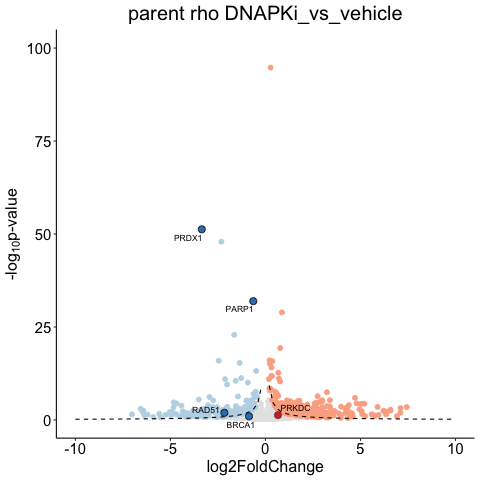

In [122]:
%%R -i df,screen_name

plot_volcano(df, xlim_l=-10,xlim_r=10, ylim=100,threshold=10) %>% 
    label_resistance_hit(df %>% filter(gene %in% c(
        "PRKDC"
    ))) -> p

p %>% label_sensitivity_hit(df %>% filter(gene %in% c(
        "PRDX1", 
        "RAD51", 
        "PARP1", "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

In [93]:
df.groupby("label").size()

label
sensitivity_hit      374
resistance_hit       616
gene_non_hit       19081
non-targeting       1026
dtype: int64

#### PRDX1_parent rho DNAPKi_vs_vehicle

In [122]:
screen_name = 'PRDX1_parent rho DNAPKi_vs_vehicle'

#### PRDX1_KO rho DNAPKi_vs_vehicle

In [22]:
screen_name = 'PRDX1_KO rho DNAPKi_vs_vehicle'

In [29]:
df = ann_score_df(data[screen_name][['target','log2FoldChange','padj']])

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro-deseq2/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [30]:
# df[
#     (df.label.eq('sensitivity_hit')) 
#     # &
#     # (df.gene.str.contains('DNMT'))
# ].gene.to_list()

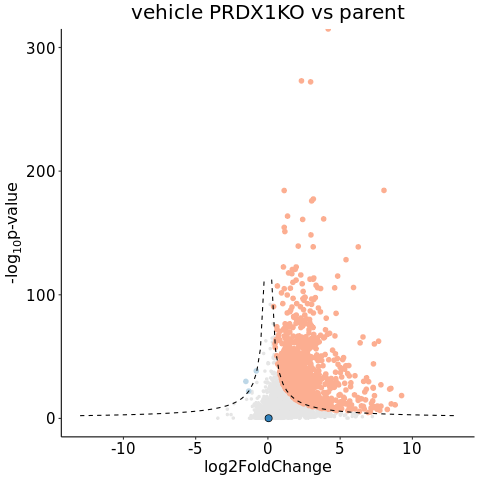

In [31]:
%%R -i df,screen_name
plot_volcano(df) %>% 
    label_sensitivity_hit(df %>% filter(gene %in% c('PRDX1'))) +
    # label_resistance_hit(df %>% filter(gene =='PARP1')) +
    ggtitle('vehicle PRDX1KO vs parent') +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

In [14]:
df.groupby("label").size()

label
sensitivity_hit        3
resistance_hit      1128
gene_non_hit       18940
non-targeting       1026
dtype: int64

#### rho vehicle_PRDX1KO_vs_vehicle_parent

In [100]:
screen_name = 'rho vehicle_PRDX1KO_vs_vehicle_parent'

In [101]:
df = ann_score_df(data[screen_name][['target','log2FoldChange','padj']])

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro-deseq2/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [121]:
df[
    # (df.label.eq('sensitivity_hit')) 
    (df.label.eq('resistance_hit')) 
    &
    (df.gene.str.contains('PRD'))
].gene.to_list()

['OPRD1', 'PRDM5', 'PRDX4', 'PRDX5', 'RPRD1A']

In [119]:
%%R 
label_black <- function(p,dd, size = 3, t_x = 0.5, t_y = 0.5){
    p + geom_point(
        data = dd, 
        size = size, shape=21,
        # stroke=0.5, 
        # colour = "grey30", 
        fill = "grey30"
    ) + 
    geom_text_repel(data = dd,
                    aes(label=gene),
                    color = 'black', size = size, nudge_x = t_x, nudge_y = t_y)
}

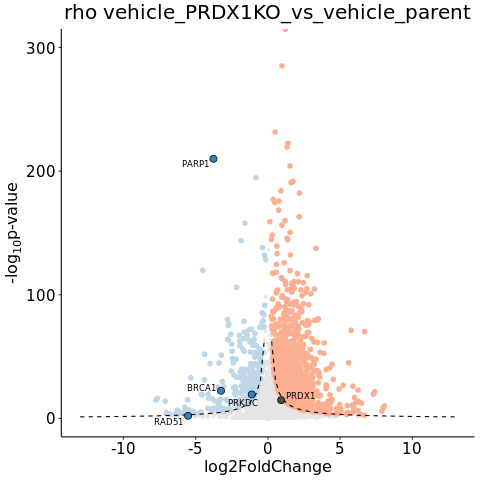

In [120]:
%%R -i df,screen_name
plot_volcano(df, ylim=300,threshold=50) %>% 
    label_black(df %>% filter(gene %in% c('PRDX1'))) -> p

p %>%
    label_sensitivity_hit(df %>% filter(gene %in% c(
        # "PRDX1", 
        "PRKDC", 
        "RAD51", 
        "PARP1", 
        "BRCA1"
    ))) +
    ggtitle(screen_name) +
    theme(axis.text.x = element_text(size = 15, color = 'black'),
          axis.text.y = element_text(size = 15, color = 'black'),
          axis.title.x = element_text(size = 16),
          axis.title.y = element_text(size = 16),
          legend.title = element_blank(),
          plot.title = element_text(size = 20,hjust = 0.5),
          legend.text = element_text(size = rel(1.5), color = 'black'),
          legend.position = 'right'
         )

In [ ]:
df.groupby("label").size()

label
sensitivity_hit      134
resistance_hit       871
gene_non_hit       19066
non-targeting       1026
dtype: int64

# Older analysis

### 
parent vehicle and KO vehicle

https://github.com/abearab/CRISPRi-dual-sgRNA-screens/tree/main

In [ ]:
cat results/vehicle_screen.txt

Index,Treat,Rep
i01,T0,1
i02,T0,2
i03,vehicle_parent,1
i04,vehicle_parent,2
i05,vehicle_parent,3
i11,vehicle_PRDX1KO,1
i12,vehicle_PRDX1KO,2
i13,vehicle_PRDX1KO,3

In [ ]:
!Rscript /data_gilbert/home/aarab/CRISPR-screenpro/CRISPRi-dual-sgRNA-screens/module2/PhenotypeScores.R \
  -i results/counts.txt \
  -s results/vehicle_screen.txt \
  -t vehicle_PRDX1KO -c vehicle_parent -z T0

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro-deseq2/lib/R/bin/exec/R: /data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro-deseq2/lib/R/bin/exec/../../lib/../.././libtinfo.so.6: no version information available (required by /data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro-deseq2/lib/R/bin/exec/../../lib/../../libreadline.so.8)
Load count matrix and samplesheet!
Run test!
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function

<div class="alert alert-block alert-info">
<!-- <b></b>  -->
    I'll ignore T0 related resluts here
</div>

In [ ]:
!mv results/counts_DESeq2_normalized.txt results/vehicle_counts_DESeq2_normalized.txt
!mv results/rho_vehicle_PRDX1KO_vs_vehicle_parent.txt results/vehicle_rho_vehicle_PRDX1KO_vs_vehicle_parent.txt

!rm results/gamma_vehicle_parent_vs_T0.txt
!rm results/tau_vehicle_PRDX1KO_vs_T0.txt

## PRDX1 parent screen

### Load meta

In [ ]:
cat results/PRDX1_parent_screen.txt

Index,Treat,Rep
i01,T0,1
i02,T0,2
i03,vehicle,1
i04,vehicle,2
i05,vehicle,3
i06,DNAPKi,1
i07,DNAPKi,2
i08,DNAPKi,3

In [ ]:
!Rscript /data_gilbert/home/aarab/CRISPR-screenpro/CRISPRi-dual-sgRNA-screens/module2/PhenotypeScores.R \
  -i results/counts.txt \
  -s results/PRDX1_parent_screen.txt \
  -t DNAPKi -c vehicle -z T0

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro-deseq2/lib/R/bin/exec/R: /data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro-deseq2/lib/R/bin/exec/../../lib/../.././libtinfo.so.6: no version information available (required by /data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro-deseq2/lib/R/bin/exec/../../lib/../../libreadline.so.8)
Load count matrix and samplesheet!
Run test!
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function

In [ ]:
!mv results/counts_DESeq2_normalized.txt results/PRDX1_parent_counts_DESeq2_normalized.txt
!mv results/rhoRDNAPKi_vs_vehicle.txt results/PRDX1_parent_rhoRDNAPKi_vs_vehicle.txt
!mv results/gammaRvehicle_vs_T0.txt results/PRDX1_parent_gammaRvehicle_vs_T0.txt
!mv results/tauRDNAPKi_vs_T0.txt results/PRDX1_parent_tauRDNAPKi_vs_T0.txt

## PRDX1 KO screen

In [ ]:
cat results/PRDX1_KO_screen.txt

Index,Treat,Rep
i09,T0,1
i10,T0,2
i11,vehicle,1
i12,vehicle,2
i13,vehicle,3
i14,DNAPKi,1
i15,DNAPKi,2
i16,DNAPKi,3

In [ ]:
!Rscript /data_gilbert/home/aarab/CRISPR-screenpro/CRISPRi-dual-sgRNA-screens/module2/PhenotypeScores.R \
  -i results/counts.txt \
  -s results/PRDX1_KO_screen.txt \
  -t DNAPKi -c vehicle -z T0

/data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro-deseq2/lib/R/bin/exec/R: /data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro-deseq2/lib/R/bin/exec/../../lib/../.././libtinfo.so.6: no version information available (required by /data_gilbert/home/aarab/anaconda3/envs/mamba/envs/screenpro-deseq2/lib/R/bin/exec/../../lib/../../libreadline.so.8)
Load count matrix and samplesheet!
Run test!
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function

In [ ]:
!mv results/counts_DESeq2_normalized.txt results/PRDX1_KO_counts_DESeq2_normalized.txt
!mv results/rhoRDNAPKi_vs_vehicle.txt results/PRDX1_KO_rhoRDNAPKi_vs_vehicle.txt
!mv results/gammaRvehicle_vs_T0.txt results/PRDX1_KO_gammaRvehicle_vs_T0.txt
!mv results/tauRDNAPKi_vs_T0.txt results/PRDX1_KO_tauRDNAPKi_vs_T0.txt

### load data / save as excel

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
def sort_scores(score):
    score['targetType'] = ''
    score.loc[score.target.eq('non-targeting'),'targetType']  = "non-targeting"
    score.loc[~score.target.eq('non-targeting'),'targetType'] = 'gene'
    
    score = score.sort_values(['targetType','target']).drop('targetType',axis=1)
    
    return score


def merge_phenotype_scores(screenname):
    gamma = pd.read_csv(f'results/{screenname}_gamma_vehicle_vs_T0.txt',sep='\t')
    gamma = sort_scores(gamma)
    rho   = pd.read_csv(f'results/{screenname}_rho_DNAPKi_vs_vehicle.txt',sep='\t')
    rho   = sort_scores(rho)
    tau   = pd.read_csv(f'results/{screenname}_tau_DNAPKi_vs_T0.txt',sep='\t')
    tau   = sort_scores(tau)
    cols  = ['target','log2FoldChange','pvalue','padj']
    
    data  = pd.concat({
        f'{screenname} gamma vehicle_vs_T0':gamma[cols], 
        f'{screenname} tau DNAPKi_vs_T0':tau[cols],
        f'{screenname} rho DNAPKi_vs_vehicle':rho[cols]
    },axis=1
    )
    
    return data

In [ ]:
rho   = pd.read_csv('results/vehicle_rho_vehicle_PRDX1KO_vs_vehicle_parent.txt',sep='\t')
rho   = sort_scores(rho)
cols  = ['target','log2FoldChange','pvalue','padj']

data = pd.concat([
    merge_phenotype_scores('PRDX1_KO'),
    merge_phenotype_scores('PRDX1_parent'),
    pd.concat({'rho vehicle_PRDX1KO_vs_vehicle_parent':rho[cols]},axis=1)
],axis=1)

In [ ]:
data.to_excel('phenotype_scores.xlsx')

In [20]:
set(data.columns.to_frame()[0].to_list())

{'PRDX1_KO gamma vehicle_vs_T0',
 'PRDX1_KO rho DNAPKi_vs_vehicle',
 'PRDX1_KO tau DNAPKi_vs_T0',
 'PRDX1_parent gamma vehicle_vs_T0',
 'PRDX1_parent rho DNAPKi_vs_vehicle',
 'PRDX1_parent tau DNAPKi_vs_T0',
 'rho vehicle_PRDX1KO_vs_vehicle_parent'}

# 

In [74]:
%load_ext watermark

In [77]:
%watermark

Last updated: 2023-05-24T12:36:29.317245-07:00

Python implementation: CPython
Python version       : 3.11.3
IPython version      : 8.12.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.4.0
Machine     : x86_64
Processor   : i386
CPU cores   : 10
Architecture: 64bit



In [78]:
%watermark --iversions

anndata: 0.8.0
pandas : 1.5.3

